## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sun Jan 21 17:14:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Grounding DINO and Segment Anything Model

Our project will use two groundbreaking designs - [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) - for zero-shot detection and [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything) - for converting boxes into segmentations. We have to install them first.


In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 421 (delta 138), reused 132 (delta 125), pack-reused 237
Receiving objects: 100% (421/421), 12.85 MiB | 14.89 MiB/s, done.
Resolving deltas: 100% (215/215), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━

In [ ]:
%cd {HOME}

import sys
!{sys.executable} -m pip infrom PIL import Image


**NOTE:** To glue all the elements of our demo together we will use the [`supervision`](https://github.com/roboflow/supervision) pip package, which will help us **process, filter and visualize our detections as well as to save our dataset**. A lower version of the `supervision` was installed with Grounding DINO. However, in this demo we need the functionality introduced in the latest versions. Therefore, we uninstall the current `supervsion` version and install version `0.6.0`.



In [ ]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

**NOTE:** At the end of the tutorial we will upload our annotations to [Roboflow](roboflow.com). To automate this process with the API, let's install the `roboflow` pip package.

### Download Grounding DINO Model Weights

To run Grounding DINO we need two files - configuration and model weights. The configuration file is part of the [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) repository, which we have already cloned. The weights file, on the other hand, we need to download. We write the paths to both files to the `GROUNDING_DINO_CONFIG_PATH` and `GROUNDING_DINO_CHECKPOINT_PATH` variables and verify if the paths are correct and the files exist on disk.

In [ ]:
import os

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

In [ ]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

In [ ]:
import os

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

### Download Segment Anything Model (SAM) Weights

As with Grounding DINO, in order to run SAM we need a weights file, which we must first download. We write the path to local weight file to `SAM_CHECKPOINT_PATH` variable and verify if the path is correct and the file exist on disk.

In [ ]:
# %cd {HOME}
# !mkdir -p {HOME}/weights
# %cd {HOME}/weights

# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
# import os

# SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
# print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

## Load models

In [ ]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Grounding DINO Model

In [ ]:
%cd {HOME}/GroundingDINO




In [ ]:

from groundingdino.util.inference import Model

In [ ]:
grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

### Load Segment Anything Model (SAM)

In [ ]:
!git clone https://github.com/piyushgit011/MobileSAM.git

In [ ]:
%cd MobileSAM
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

model_type = "vit_t"
sam_checkpoint = "./weights/mobile_sam.pt"

device = "cuda"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()
# image = cv2.imread(ima.png)
sam_predictor = SamPredictor(mobile_sam)
%cd ..

In [ ]:
!git clone https://github.com/wildoctopus/huggingface-cloth-segmentation.git
!unzip huggingface-cloth-segmentation.zip

%cd huggingface-cloth-segmentation
!git lfs install

!git clone https://huggingface.co/piyushaaryan011/cloth_segm
!pip install -r requirements.txt

%cd ..

Cloning into 'huggingface-cloth-segmentation'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 28 (delta 7), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (28/28), 1.96 MiB | 13.39 MiB/s, done.
Resolving deltas: 100% (7/7), done.
unzip:  cannot find or open huggingface-cloth-segmentation.zip, huggingface-cloth-segmentation.zip.zip or huggingface-cloth-segmentation.zip.ZIP.
/content/GroundingDINO/huggingface-cloth-segmentation
Updated git hooks.
Git LFS initialized.
Cloning into 'cloth_segm'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (6/6), 2.10 KiB | 2.10 MiB/s, done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 

## Single Image Mask Auto Annotation

Before we automatically annotate the entire dataset let's focus for a moment on a single image.

In [ ]:
from getpass import getpass
import os

REPLICATE_API_TOKEN = 'r8_BihSJBzDmJ02tV7mmcOUUKLy9k7fWAZ46QbGW'
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

In [ ]:
%cd huggingface-cloth-segmentation
from google.colab import files

uploaded = files.upload()

if len(uploaded) > 0:

    new_file_name = "1.png"

    uploaded_file_name = list(uploaded.keys())[0]

    import os
    os.rename(uploaded_file_name, new_file_name)

/content/GroundingDINO/huggingface-cloth-segmentation


Saving 1.png to 1.png


# mask

**NOTE:** To get better Grounding DINO detection we will leverage a bit of prompt engineering using `enhance_class_name` function defined below. 👇 You can learn more from our [Grounding DINO tutorial](https://blog.roboflow.com/grounding-dino-zero-shot-object-detection/).

In [ ]:
import subprocess
# Set the locale to UTF-8 for the subprocess
subprocess.run('export LC_ALL=en_US.UTF-8', shell=True, check=True)

# Run your Python script using subprocess
subprocess.run('python process.py --image "1.png" --checkpoint_path "/content/GroundingDINO/huggingface-cloth-segmentation/cloth_segm/cloth_segm.pth"', shell=True, check=True)
# !python process.py --image "2.png"

%cd ..

CalledProcessError: Command 'python process.py --image "1.png" --checkpoint_path "/content/GroundingDINO/huggingface-cloth-segmentation/cloth_segm/cloth_segm.pth"' returned non-zero exit status 2.

In [ ]:
SOURCE_IMAGE_PATH = f"{HOME}/GroundingDINO/huggingface-cloth-segmentation/1.png"
# CLASSES = ['face','neck','glasses','hat','hair','beard','earrings']
CLASSES = ['person']
BOX_TRESHOLD = 0.40
TEXT_TRESHOLD = 0.25

In [ ]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

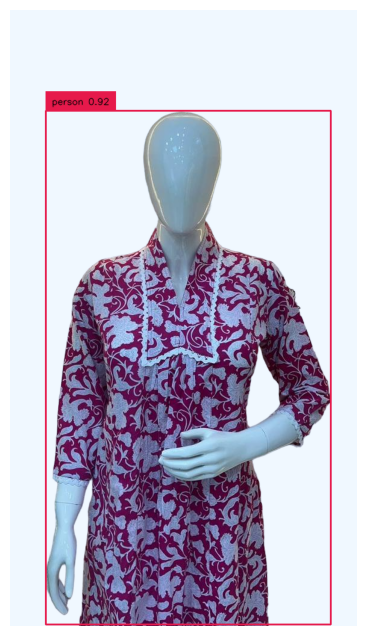

In [ ]:
import cv2
import supervision as sv

# load image

image = cv2.imread(SOURCE_IMAGE_PATH)
# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (8, 8))

In [ ]:
import numpy as np
# from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

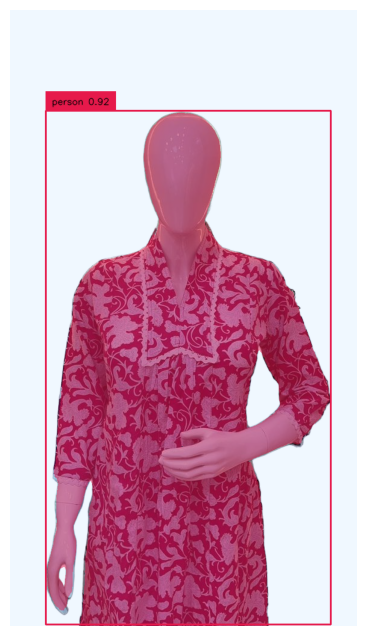

In [ ]:
import cv2

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image1 = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

# cv2.imwrite('mask.png',annotated_image)
%matplotlib inline
sv.plot_image(annotated_image1, (8, 8))

In [ ]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image

mask_pil = Image.fromarray(detections.mask[0])
# image_pil = Image.fromarray(image)
mask_pil.save('mask.png')
image = cv2.imread('mask.png')

try:
  for mask_image in detections.mask:
     i = 0
     i= i+1
     mask_pil = Image.fromarray(mask_image)
     mask_pil.save(f'mask{i}.png')
     image1 = cv2.imread(f'mask{i}.png')
     image = cv2.bitwise_or(image1, image)


  output_path = f"mask.png"
  cv2.imwrite(output_path, image)
except:
  print('no more masks')

In [ ]:
import cv2
import os

def merge_masks_in_directory(directory_path):
    try:
        # List all files in the directory
        files = os.listdir(directory_path)

        # Initialize an empty mask
        merged_mask = None

        # Iterate over each file in the directory and merge the masks
        for file_name in files:
            file_path = os.path.join(directory_path, file_name)

            # Check if the path is a file (not a subdirectory)
            if os.path.isfile(file_path):
                # Read the mask image
                mask = cv2.imread(file_path)

                # Initialize the merged_mask if it's not initialized yet
                if merged_mask is None:
                    merged_mask = mask
                else:
                    # Merge the current mask with the existing merged_mask using cv2.bitwise_or
                    merged_mask = cv2.bitwise_or(merged_mask, mask)

        # Save or further process the merged mask
        return merged_mask
    except Exception as e:
        print(f"Error: {e}")

In [ ]:
import cv2
cloth_mask = merge_masks_in_directory("huggingface-cloth-segmentation/output/alpha")
# cloth_mask2 = cv2.imread("huggingface-cloth-segmentation/output/alpha/2.png")
# cloth_mask = cv2.bitwise_or(cloth_mask1,cloth_mask2)

In [ ]:
import os

for file in os.listdir("huggingface-cloth-segmentation/output/alpha"):
  os.remove(os.path.join("huggingface-cloth-segmentation/output/alpha", file))

In [ ]:
# SOURCE_IMAGE_PATH = f"{HOME}/GroundingDINO/1.png"
# CLASSES = ['face','neck','glasses','hat','hair','beard','earrings']
CLASSES = ['hair']
BOX_TRESHOLD = 0.50
TEXT_TRESHOLD = 0.25

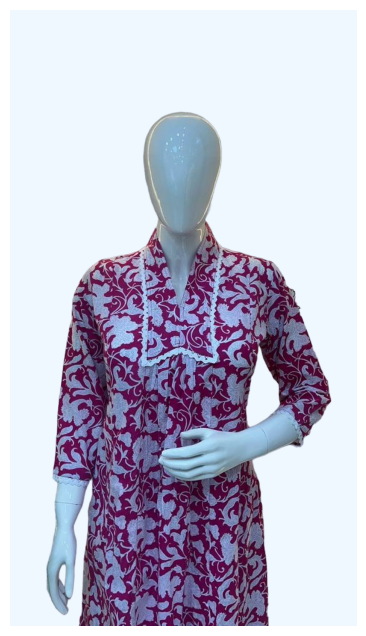

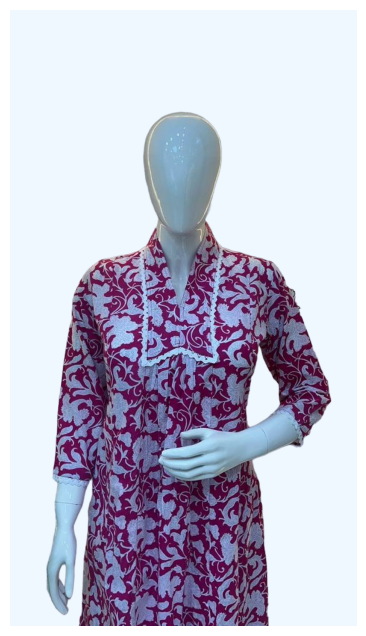

no hair


In [ ]:
image = cv2.imread(SOURCE_IMAGE_PATH)
# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (8, 8))


# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image1 = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

# cv2.imwrite('head_mask.png',annotated_image)
%matplotlib inline
sv.plot_image(annotated_image1, (8, 8))
try:
  mask_pil = Image.fromarray(detections.mask[0])
# image_pil = Image.fromarray(image)
  mask_pil.save('head_mask.png')
except:
  print("no hair")

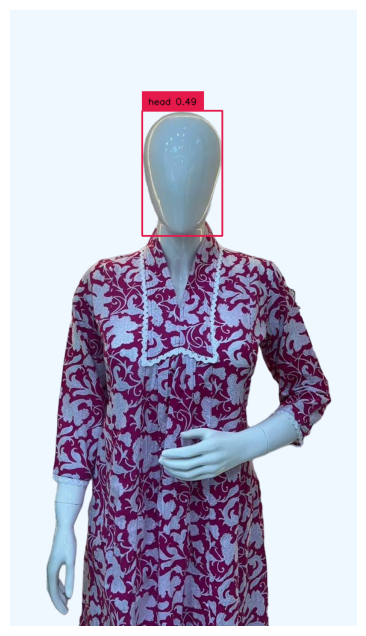

In [ ]:
# hair_mask = cv2.imread('head_mask.png')
if detections.xyxy is not None:
   SOURCE_IMAGE_PATH = f"{HOME}/GroundingDINO/huggingface-cloth-segmentation/1.png"
   # CLASSES = ['face','neck','glasses','hat','hair','beard','earrings']
   CLASSES = ['head']
   BOX_TRESHOLD = 0.36
   TEXT_TRESHOLD = 0.25
   image = cv2.imread(SOURCE_IMAGE_PATH)
   # detect objects
   detections = grounding_dino_model.predict_with_classes(
       image=image,
       classes=enhance_class_name(class_names=CLASSES),
       box_threshold=BOX_TRESHOLD,
       text_threshold=TEXT_TRESHOLD
   )

   # annotate image with detections
   box_annotator = sv.BoxAnnotator()
   labels = [
       f"{CLASSES[class_id]} {confidence:0.2f}"
       for _, _, confidence, class_id, _
       in detections]
   annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

   %matplotlib inline
   sv.plot_image(annotated_frame, (8, 8))

   for x1, y1, x2, y2 in detections.xyxy:
    # Extract the region of interest using bounding box coordinates
     y1 = y1 - 20
     y2 = y2 + 20
     x1 = x1 - 30
     x2 = x2 + 30
     x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
     mask = np.zeros_like(image, dtype=np.uint8)
     cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green rectangle
     cv2.rectangle(mask, (x1, y1), (x2, y2), (255, 255, 255), thickness=cv2.FILLED)
    #  face_cutout = image[y1:x2, y1:y2]
     cutout = image[y1:y2, x1:x2]

   cv2.imwrite("head_mask.png", mask)
# except:
#   print('no head mask')
# cv2.imwrite("face.png",face_cutout)



In [ ]:
mask2 = cv2.imread("mask.png")

skin_mask = cv2.subtract(mask2,cloth_mask)

mask1 = cv2.imread("head_mask.png")


merge = cv2.bitwise_or(mask1,skin_mask)

cv2.imwrite("final_mask.png",merge)



error: OpenCV(4.8.0) /io/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


# diffusion api


In [ ]:
import replicate

output = replicate.run(
    "konieshadow/fooocus-api:a7e8fa2f96b01d02584de2b3029a8452b9bf0c8fa4127a6d1cfd406edfad54fb",
    input={
        "prompt": "beautiful person ","negative_prompt": "imperfect hands, invisible person, invisible head","performance_selection":"Quality", "inpaint_input_image":open("huggingface-cloth-segmentation/1.png", "rb"), "inpaint_input_mask": open("final_mask.png", "rb")
    }
)
print(output)

ReplicateError: You have reached the free time limit. To continue using Replicate, set up billing at https://replicate.com/account/billing#billing.

In [ ]:
from PIL import Image
import requests
from io import BytesIO

# Replace 'image_url' with the URL
response = requests.get(output[0])

if response.status_code == 200:
    # Read the image data from the response
    image_data = response.content

    # Use BytesIO to create a binary stream from the image data
    image_stream = BytesIO(image_data)

    # Open the image using Pillow
    img = Image.open(image_stream)

    # Show the image
    # img.show()
    img.save('/content/2.png')